In [1]:
%pylab inline
import networkx as nx
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
layout_dict = dict()

def draw_network_plot(graph, color_dict=None):
    global layout_dict
    
    if graph.name not in layout_dict:
        layout_dict[graph.name] = nx.spring_layout(graph)
        
    layout = layout_dict[graph.name]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    nx.draw_networkx(G, ax=ax, node_color=color_dict, pos=layout)
    
    
as_series = lambda x: pd.Series(dict(x)).sort_values(ascending=False)

## The Data

Quick. Forget *everything* you know about Renaissance Italy.

Okay cool. Now, let's take a look at a few of the major families.

**Note**: For simplicity this data model doesn't burden us with keeping all family *members* straight. Similarly, all of the edges represent *symmetric* relationships from family to family (e.g. marriage, pact, etc) and doesn't allow for such realistic, *directioned* relationships as "owes money to," "insulted," or anything of that nature.

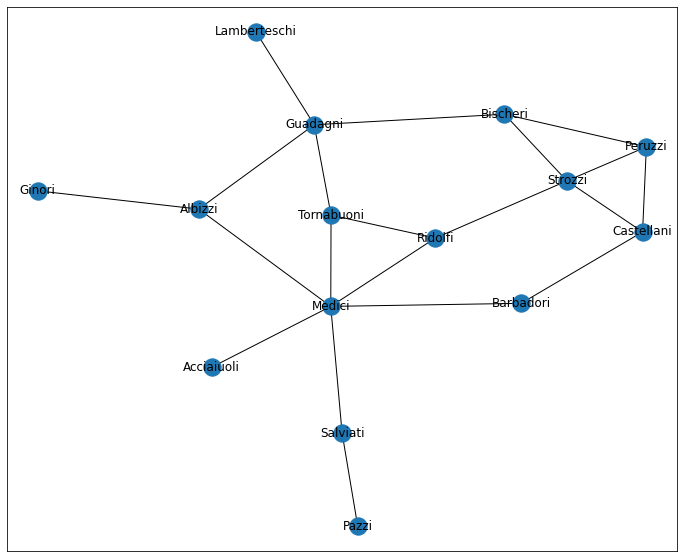

In [3]:
G = nx.florentine_families_graph()
G.name = 'florentine'

draw_network_plot(G)

Looking at this, and considering the famous-ish-ness of the data, we might be inclined to ask: "which family is most powerful and why?"-- I'm sure 15th century Italy did.

In a graph context, we might consider "most powerful" as "most important." So how, then, do we determine a node's importance in a network?

## Various Centrality Measures

There's no one-size-fits-all measure of a node's centrality within a network. As such, I'm going to breeze through a few popular metrics and give a brief overview of their trade-offs.

### Degree Centrality

This is an easy one. And probably the most intuitive. "What percent of all other nodes is this node connected to?"

In [4]:
dc = nx.degree_centrality(G)
dc = pd.Series(dc, name='degree')

dc.sort_values(ascending=False)

Medici          0.428571
Guadagni        0.285714
Strozzi         0.285714
Bischeri        0.214286
Albizzi         0.214286
Tornabuoni      0.214286
Ridolfi         0.214286
Peruzzi         0.214286
Castellani      0.214286
Salviati        0.142857
Barbadori       0.142857
Lamberteschi    0.071429
Ginori          0.071429
Pazzi           0.071429
Acciaiuoli      0.071429
Name: degree, dtype: float64

Here, the Medicis are the clear frontrunner, nearly twice the value of the second-most-central family.

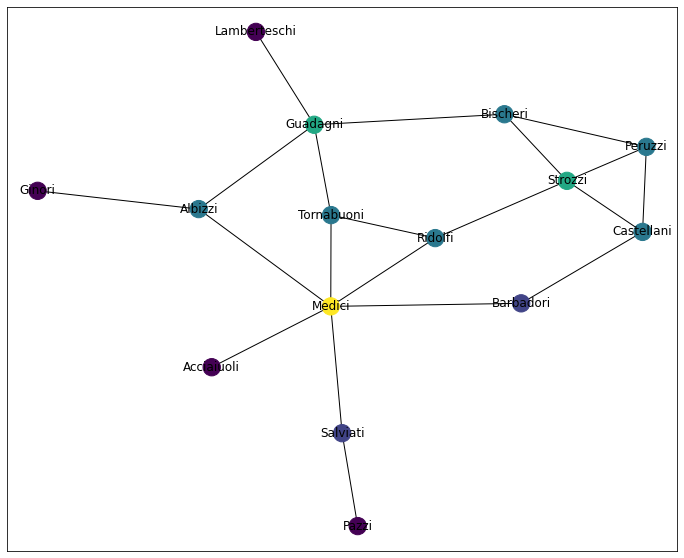

In [5]:
draw_network_plot(G, dc)

In [6]:
as_series(nx.degree(G))

Medici          6
Guadagni        4
Strozzi         4
Bischeri        3
Albizzi         3
Tornabuoni      3
Ridolfi         3
Peruzzi         3
Castellani      3
Salviati        2
Barbadori       2
Lamberteschi    1
Ginori          1
Pazzi           1
Acciaiuoli      1
dtype: int64

### Closeness Centrality

Closeness centrality measures "how close is this node to every other node" by taking, for each node,

```
1 / avg_dist_to_all_nodes
```

or 

In [7]:
(
    1 / (
        sum(
            np.fromiter(
               (nx.shortest_path_length(G, 'Medici', other)
                for other in G.nodes
                if other != 'Medici'),
                dtype=np.float64
            )
       ) / (len(G.nodes) - 1)
   )
)

0.5599999999999999

this is wedged between two extremes:

* `0`: the node is disconnected from everything
* `1`: the node is a 'hub' and one step away from all other nodes in the network

In [8]:
cc = nx.closeness_centrality(G)
cc = pd.Series(cc, name='closeness')

cc.sort_values(ascending=False)

Medici          0.560000
Ridolfi         0.500000
Albizzi         0.482759
Tornabuoni      0.482759
Guadagni        0.466667
Barbadori       0.437500
Strozzi         0.437500
Bischeri        0.400000
Salviati        0.388889
Castellani      0.388889
Peruzzi         0.368421
Acciaiuoli      0.368421
Ginori          0.333333
Lamberteschi    0.325581
Pazzi           0.285714
Name: closeness, dtype: float64

An even-er playing field.

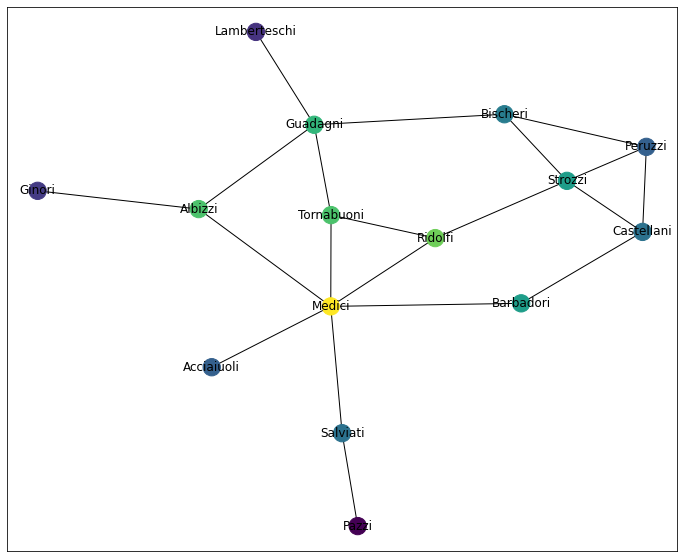

In [9]:
draw_network_plot(G, cc)

This shouldn't come as a huge shock, however, as there isn't a TON of variation between max and min distance between any two nodes.

In [10]:
nx.radius(G)

3

In [11]:
nx.diameter(G)

5

In [12]:
nx.eccentricity(G, 'Medici')

3

### Harmonic Centrality

This is VERY similar to Closeness Centrality. The key difference is where you're doing the averaging.

With Closeness Centrality, we averaged in the denominator. Here, we average the whole fraction, like so:

```
sum( 1 / (
          (dist(other) for other in nodes)
   ) / (n / 1)
```

or

In [13]:
sum(
    1 /
    np.fromiter(
                (nx.shortest_path_length(G, 'Medici', other)
                    for other in G.nodes
                    if other != 'Medici'),
                dtype=np.float64)
   )

9.5

Unfortunately, `networkx` doesn't normalize the values like they do with Closeness Centrality.

In [14]:
hc = nx.harmonic_centrality(G)
hc = pd.Series(hc, name='harmonic')

hc.sort_values(ascending=False)

Medici          9.500000
Guadagni        8.083333
Ridolfi         8.000000
Albizzi         7.833333
Tornabuoni      7.833333
Strozzi         7.833333
Bischeri        7.200000
Barbadori       7.083333
Castellani      6.916667
Peruzzi         6.783333
Salviati        6.583333
Acciaiuoli      5.916667
Lamberteschi    5.366667
Ginori          5.333333
Pazzi           4.766667
Name: harmonic, dtype: float64

For the sake of being able to compare Centrality measure to Centrality measure, we'll do that now

In [15]:
hc = nx.harmonic_centrality(G)
hc = pd.Series(hc, name='harmoinic') / (len(hc) - 1)

hc.sort_values(ascending=False)

Medici          0.678571
Guadagni        0.577381
Ridolfi         0.571429
Albizzi         0.559524
Tornabuoni      0.559524
Strozzi         0.559524
Bischeri        0.514286
Barbadori       0.505952
Castellani      0.494048
Peruzzi         0.484524
Salviati        0.470238
Acciaiuoli      0.422619
Lamberteschi    0.383333
Ginori          0.380952
Pazzi           0.340476
Name: harmoinic, dtype: float64

At this point, you might find yourself jumping back and forth between this graph an the Closeness Centrality graph. I know I did, and I'm the one writing this damn notebook, lol

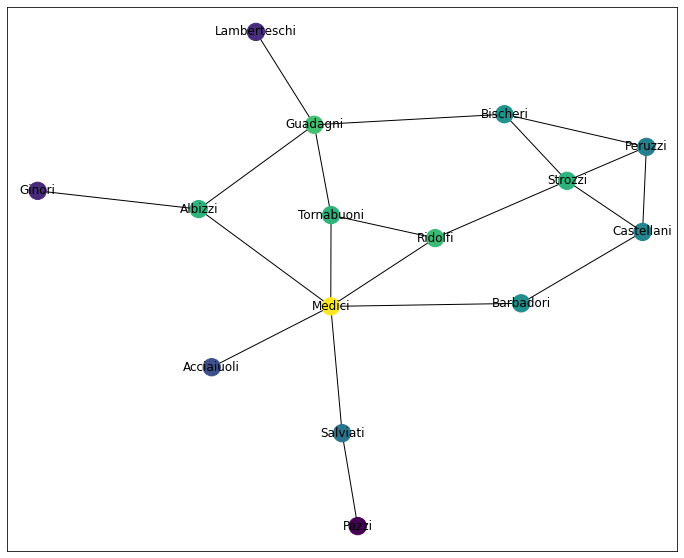

In [16]:
draw_network_plot(G, hc)

Unfortunately, the book doesn't really expound on the difference between the two, merely offering

>When the closeness of a node is equal to 0 or 1, the harmonic closeness is also near 0 or 1. However, the two centralities in general differ and in the case of [the sample dataset the book had used to this point] are not even strongly correlated

Bummer.

Thankfully, a bit of poking around and [these Neo4j docs](https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/harmonic-centrality/) mention that the Harmonic Centrality was "invented to solve the problem the original formula had when dealing with unconnected graphs." And that's good enough for me :)

### Betweenness

Betweenness centrality is a really interesting one. It measures "the fraction of all possible geodesics that pass thorugh a node" and is essentially a measure of "how much is this node an essential go-between for any two given nodes?"

So we'll start by generating a list of all pairs in a Network

In [17]:
from itertools import combinations

all_pairs = list(
    (a, b)
    for (a, b) in combinations(G.nodes, 2)
    if a != b
)

# dedupe ('medici', 'albizzi') vs ('albizzi', 'medici')
all_pairs = list(set(
    tuple(sorted((a, b))) for (a, b) in all_pairs
))

Then, we'll remove all mentions of `'Medici'`-- it doesn't make a ton of sense to consider the Medici family "between" themselves and another family, yeah?

In [18]:
non_medici = [
    pair
    for pair in all_pairs
    if 'Medici' not in pair
]

len(non_medici)

91

This is good. We expect 91 pairs because in a graph of size

In [19]:
len(G)

15

Subtracting 1 (`'Medici'`) and applying the "number of pairs" formula matches

In [20]:
(14 * 13) / 2

91.0

And so basically, we want to calculate "of all shortest paths between any two nodes, how often is 'Medici' a part of that path?"

In [21]:
sum(
    np.fromiter(
        ('Medici' in nx.shortest_path(G, node_a, node_b)
         for (node_a, node_b) in non_medici),
        dtype=np.float64
    )
) / len(non_medici)

0.5384615384615384

Finally, it's worth mentioning that this is an `O(n^2)` operation and thus scales pretty miserably, compared to the `O(n)`ish measures we've seen thus far.

Therefore our numbers are *a little* off, because `networkx` does some interesting sampling magic behind the scenes to make the computation tractable.

In [22]:
bc = nx.betweenness_centrality(G, normalized=True)
bc = pd.Series(bc, name='betweenness')

bc.sort_values(ascending=False)

Medici          0.521978
Guadagni        0.254579
Albizzi         0.212454
Salviati        0.142857
Ridolfi         0.113553
Bischeri        0.104396
Strozzi         0.102564
Barbadori       0.093407
Tornabuoni      0.091575
Castellani      0.054945
Peruzzi         0.021978
Lamberteschi    0.000000
Ginori          0.000000
Pazzi           0.000000
Acciaiuoli      0.000000
Name: betweenness, dtype: float64

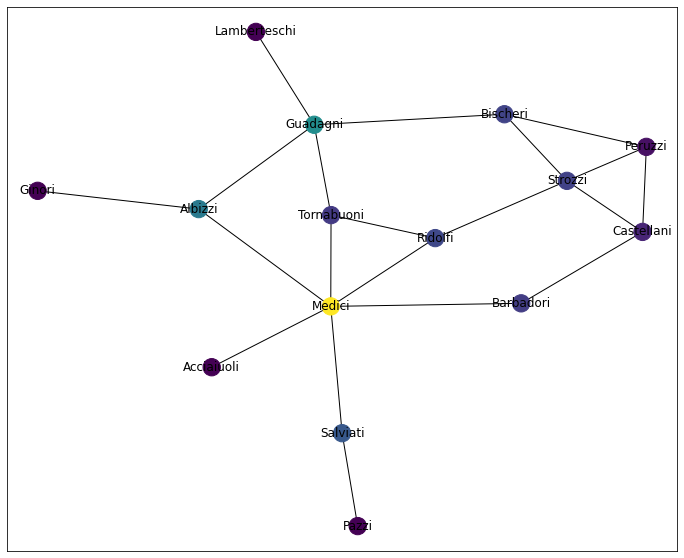

In [23]:
draw_network_plot(G, bc)

### Eigen(vector) Centrality

Jury's still out on the specific *interpretation* of this measure ([link to unanswered GitHub question, at the time of writing](https://github.com/networkx/networkx/issues/4650)), but the *general idea* is reasonably-simple to follow:

* Eigenvector Centrality starts off randomly-instantiated, then is *recursively generated* from the network
* For a given node, connections to high-Eigenvector Centrality contribute more to the node's score than low-scoring nodes

Or as the author of the books puts it

> "Tell me who your friends are and I'll tell you who *you* are"

Which seems to apply some notion of assorativity, yeah?

More generally, this measure is particularly useful in contexts where communication within a network happens over long distances. Here, the position of a node *in the global structure* counts for more than how *locally connected* a node might be.

In [24]:
ec = nx.eigenvector_centrality(G)
ec = pd.Series(ec, name='eigenvector')

ec.sort_values(ascending=False)

Medici          0.430315
Strozzi         0.355973
Ridolfi         0.341554
Tornabuoni      0.325847
Guadagni        0.289117
Bischeri        0.282794
Peruzzi         0.275722
Castellani      0.259020
Albizzi         0.243961
Barbadori       0.211706
Salviati        0.145921
Acciaiuoli      0.132157
Lamberteschi    0.088793
Ginori          0.074925
Pazzi           0.044815
Name: eigenvector, dtype: float64

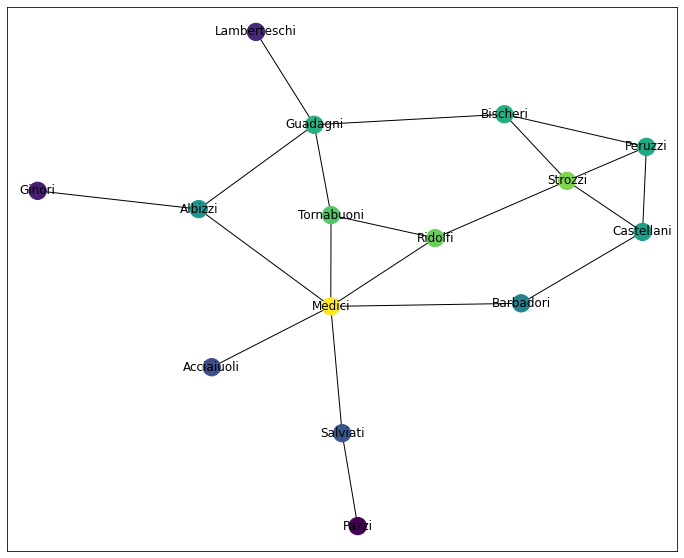

In [25]:
draw_network_plot(G, ec)

### Page Rank

Like Eigenvector Centrality, PageRank is a *recursively defined* Centrality Measure that considers the scores of a node's neighbors in the score calculation for a given node. But whereas Eigenvector Centrality is a plug-and-chug calculation of the adjacency matrix, PageRank employs a more tangible algorithm.

All told, a node's PageRank score (loosely) represents "the probability that a person randomly traversing edges will arrive at the node." We say 'probability' because there's an element of chance at play here.

Let's back up.

PageRank is an algorithm that works *exclusively* on **Directed** graphs. When we pass in an *undirected* graph-- like the one we've been working with thus far-- under the hood, we re-cast this as a Directed Graph with twice as many edges (one for each direction). Then, we re-weight each edge such that all of the weights add to 1 (we can bias the starting condition, but let's ignore that for now).

Then `networkx` pipes this DiGraph into a Stochastic Graph object, which essentially uses the edge weights to simulate random walks through the network.

Using this, [we simulate several rounds where we](https://networkx.org/documentation/stable/_modules/networkx/algorithms/link_analysis/pagerank_alg.html#pagerank):

- Simulate random movement through the network
- Tabulate how much our data has sunk into `dangling_nodes`-- or nodes that don't have an out edge-- the more data pooling in the terminal nodes, the more *important* those terminal nodes
- Similarly, when the terminal nodes increase in value, *the nodes responsible for pushing data to them become more valueable*
- Thus, we back-propogate a big chunk of value to the penultimate nodes, a moderate chunk to the second-to-last nodes, etc, etc

This runs until the aggregate, intra-node, round-to-round movements converge to some small value and we're left with a network that's more or less stable.

The wrinkle-- and indeed, the brilliance-- to all of this, is that at each step, there's an `alpha` value (default=`.85`) that the simulated user/entity will move again after this round. Or stated in the reverse, there's a `p=.15` chance they just stop at whatever node they were at, on round `t`.

This allows for some interesting (and more-realistic) simulation of user behavior. At the two extremes:

- `alpha=1`: All actors move until they sink into a node with no way out (think long-term Markov Chain behavior). Calculate PageRank accordingly.
- `alpha=0`: There's a `p=1.00` chance that the agents don't take a single step. Page Rank will just be `1 / N` for each node.

Thus, picking the correct value for `alpha` means striking a balance that finds "realistic randomness."

But until we know what we're doing, let's stick with the default, lol

In [26]:
pr = nx.pagerank(G)
pr = pd.Series(pr, name='pagerank')

pr.sort_values(ascending=False)

Medici          0.145818
Guadagni        0.098399
Strozzi         0.088098
Albizzi         0.079122
Tornabuoni      0.071279
Ridolfi         0.069574
Castellani      0.069330
Bischeri        0.068862
Peruzzi         0.067875
Salviati        0.061303
Barbadori       0.050301
Pazzi           0.036054
Ginori          0.032418
Lamberteschi    0.030909
Acciaiuoli      0.030657
Name: pagerank, dtype: float64

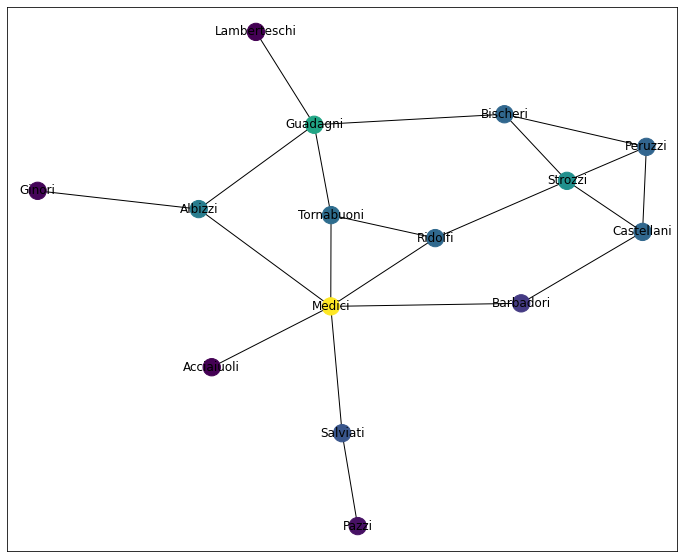

In [27]:
draw_network_plot(G, pr)

Making a note of it here, the book mentions "HITS Hubs and Authorities" as *similar, but opposite* approaches to PageRank. Will come back and update these notes if I find that it's convincingly-different from what we've covered thus far.

In [28]:
hits = nx.hits(G)
hits = pd.Series(hits[0], name='hits')

## So What's "Best?" 

*Whatever that means....*

For starters, let's merge all of the results into one big ol' DataFrame

In [29]:
df = pd.concat([dc, cc, hc, ec, bc, pr, hits], axis=1)
df

,degree,closeness,harmoinic,eigenvector,betweenness,pagerank,hits
Acciaiuoli,0.071429,0.368421,0.422619,0.132157,0.000000,0.030657,0.037730
Medici,0.428571,0.560000,0.678571,0.430315,0.521978,0.145818,0.122853
Castellani,0.214286,0.388889,0.494048,0.259020,0.054945,0.069330,0.073952
Peruzzi,0.214286,0.368421,0.484524,0.275722,0.021978,0.067875,0.078721
Strozzi,0.285714,0.437500,0.559524,0.355973,0.102564,0.088098,0.101633
Barbadori,0.142857,0.437500,0.505952,0.211706,0.093407,0.050301,0.060442
Ridolfi,0.214286,0.500000,0.571429,0.341554,0.113553,0.069574,0.097514
Tornabuoni,0.214286,0.482759,0.559524,0.325847,0.091575,0.071279,0.093028
Albizzi,0.214286,0.482759,0.559524,0.243961,0.212454,0.079122,0.069650
Salviati,0.142857,0.388889,0.470238,0.145921,0.142857,0.061303,0.041659


Then we'll employ the favorite blunt instrument of any Data Scientist.

In [30]:
df.corr()

,degree,closeness,harmoinic,eigenvector,betweenness,pagerank,hits
degree,1.000000,0.824514,0.929537,0.925372,0.844151,0.985759,0.925369
closeness,0.824514,1.000000,0.964901,0.868137,0.806630,0.824776,0.868119
harmoinic,0.929537,0.964901,1.000000,0.947494,0.821570,0.913117,0.947483
eigenvector,0.925372,0.868137,0.947494,1.000000,0.665501,0.864561,1.000000
betweenness,0.844151,0.806630,0.821570,0.665501,1.000000,0.913238,0.665479
pagerank,0.985759,0.824776,0.913117,0.864561,0.913238,1.000000,0.864552
hits,0.925369,0.868119,0.947483,1.000000,0.665479,0.864552,1.000000


And I'm told if you stare at this long enough, you might intuit that these measures fall, broadly, into two classes:

- Group A: ['Eigenvector', 'Harmonic', 'PageRank']
- Group B:
    - Subgroup I: ['Degree', 'Betweenness']
    - Subgroup II: ['Closeness', 'HITS']
    
He then goes on to say (emphasis mine-- words entirely his, please don't DMCA me)

>I am *almost* saying that knowing one representative measure from each group-- say, closeness, betweeness, and eigenvector centralities-- *probably* will suffice for all practical purposes. **But the final choice is yours.**

Like HITS, I'll come back and update this section if this understanding winds up biting me in the ass.